<a href="https://colab.research.google.com/github/ahmedelalaoui142/Forecasting_financial_time_series/blob/main/INTERNSHIP6_predicting_using_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
%matplotlib inline

# Set random seeds for reproducibility
import tensorflow as tf
import random
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)


In [ ]:
# Download Microsoft stock data
df = yf.download('MSFT', start='2014-01-01', end='2024-09-01')
df.sort_index(inplace=True)
data = df[['Close']]

# Define the cutoff date (two months before the last date in the dataset)
last_date = data.index[-1]
cutoff_date = last_date - pd.DateOffset(months=2)

# Split data into training and validation sets
train_data = data[data.index <= cutoff_date]
test_data = data[data.index > cutoff_date]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)


[*********************100%***********************]  1 of 1 completed


In [ ]:
# Define the lookback period
lookback = 90

# Function to create sequences
def create_sequences(dataset, lookback):
    X, Y = [], []
    for i in range(lookback, len(dataset)):
        X.append(dataset[i - lookback:i, 0])
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

# Create sequences from the scaled training data
X_train, y_train = create_sequences(scaled_train_data, lookback)
X_test, y_test = create_sequences(np.concatenate((scaled_train_data[-lookback:], scaled_test_data)), lookback)

# Reshape X_train and X_test to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], lookback, 1))
X_test = X_test.reshape((X_test.shape[0], lookback, 1))

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (2550, 90, 1)
X_test shape: (44, 90, 1)


In [ ]:
def build_model():
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True, input_shape=(lookback, 1)))
    model.add(LSTM(units=150))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


In [ ]:
# Define the range of epochs to test
epoch_values = [10, 20, 30, 40, 50, 60, 80, 100]


In [ ]:
epoch_list = []
train_loss_list = []
val_loss_list = []
rmse_list = []
mape_list = []
history_list = []


In [ ]:
for epochs in epoch_values:
    print(f"\nTraining model with {epochs} epochs...")
    model = build_model()

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=16,
        validation_data=(X_test, y_test),
        verbose=0
    )

    # Record the training and validation loss
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate RMSE and MAPE
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

    # Store the results
    epoch_list.append(epochs)
    train_loss_list.append(final_train_loss)
    val_loss_list.append(final_val_loss)
    rmse_list.append(rmse)
    mape_list.append(mape)
    history_list.append(history)

    print(f"Epochs: {epochs}, Train Loss: {final_train_loss:.6f}, Val Loss: {final_val_loss:.6f}, RMSE: {rmse:.2f}, MAPE: {mape:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training model with 10 epochs...


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(epoch_list, train_loss_list, marker='o', label='Training Loss')
plt.plot(epoch_list, val_loss_list, marker='o', label='Validation Loss')
plt.title('Training and Validation Loss vs. Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


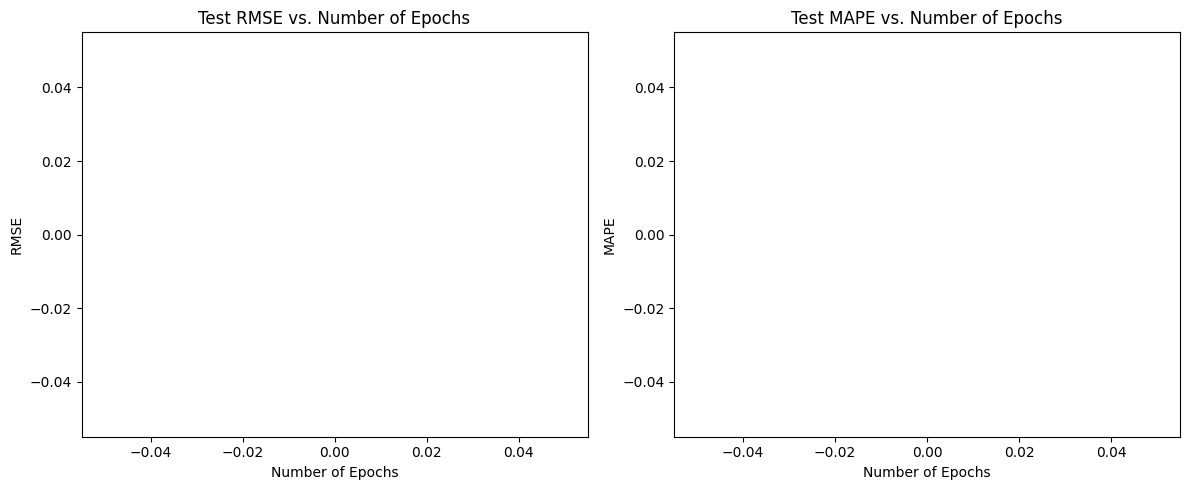

In [ ]:
# Plot RMSE vs. Number of Epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_list, rmse_list, marker='o')
plt.title('Test RMSE vs. Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')

# Plot MAPE vs. Number of Epochs
plt.subplot(1, 2, 2)
plt.plot(epoch_list, mape_list, marker='o', color='orange')
plt.title('Test MAPE vs. Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('MAPE')

plt.tight_layout()
plt.show()


In [ ]:
# Create a DataFrame to display the results
results_epochs_df = pd.DataFrame({
    'Epochs': epoch_list,
    'Train Loss': train_loss_list,
    'Validation Loss': val_loss_list,
    'Test RMSE': rmse_list,
    'Test MAPE': mape_list
})

results_epochs_df


,Epochs,Train Loss,Validation Loss,Test RMSE,Test MAPE


In [ ]:
# Plot loss curves for each epoch setting
for i, epochs in enumerate(epoch_list):
    history = history_list[i]
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves for {epochs} Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [ ]:
# Build and train the final model
final_model = build_model()
history = final_model.fit(
    X_train,
    y_train,
    epochs=100,  # Replace with your optimal number of epochs
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0126 - val_loss: 0.0019
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.7055e-04 - val_loss: 0.0021
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.7230e-04 - val_loss: 0.0013
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.4986e-04 - val_loss: 8.5731e-04
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 2.4228e-04 - val_loss: 8.8590e-04
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 2.1786e-04 - val_loss: 0.0013
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.9631e-04 - val_loss: 0.0018
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.9044e-04 - val_loss: 0.0016
Epoch 9/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.8613e-04 - val_loss: 0.0013
Epoch 10/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.8267e-04 - val_loss: 0.0010
Epoch 11/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.7816e-04 - val

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


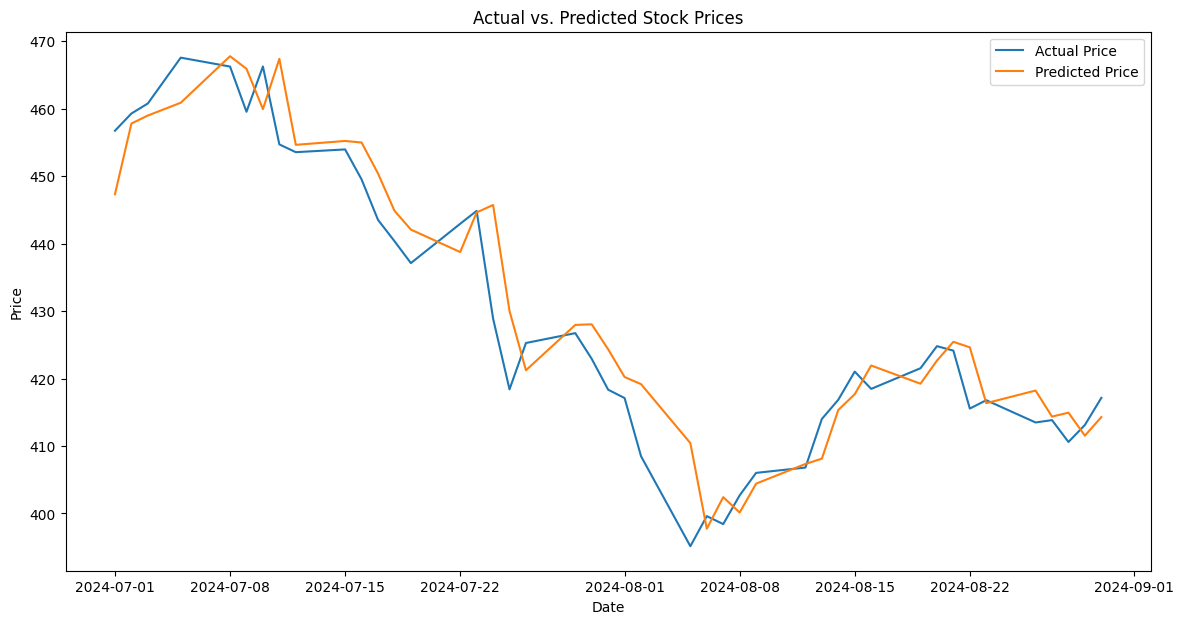

In [ ]:
# Make predictions on the test set
y_pred = final_model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a DataFrame for plotting
dates = data.index[-len(y_test_inv):]
comparison_df = pd.DataFrame({
    'Date': dates,
    'Actual': y_test_inv.flatten(),
    'Predicted': y_pred_inv.flatten()
})

# Plot the actual vs. predicted prices
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual'], label='Actual Price')
plt.plot(comparison_df['Date'], comparison_df['Predicted'], label='Predicted Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
# Calculate evaluation metrics
final_rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
final_mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

print(f'Final RMSE: {final_rmse:.2f}')
print(f'Final MAPE: {final_mape:.4f}')


Final RMSE: 6.06
Final MAPE: 0.0108


In [ ]:
# Calculate the direction for actual and predicted prices
comparison_df['Actual_Direction'] = (comparison_df['Actual'].shift(-1) > comparison_df['Actual']).astype(int)
comparison_df['Predicted_Direction'] = (comparison_df['Predicted'].shift(-1) > comparison_df['Predicted']).astype(int)

# Drop the last row because it will have a NaN in 'Actual_Direction'
comparison_df.dropna(inplace=True)


In [ ]:
# Calculate the accuracy of direction prediction
direction_accuracy = np.mean(comparison_df['Actual_Direction'] == comparison_df['Predicted_Direction'])

print(f'Direction Accuracy: {direction_accuracy:.4f}')


Direction Accuracy: 0.5909


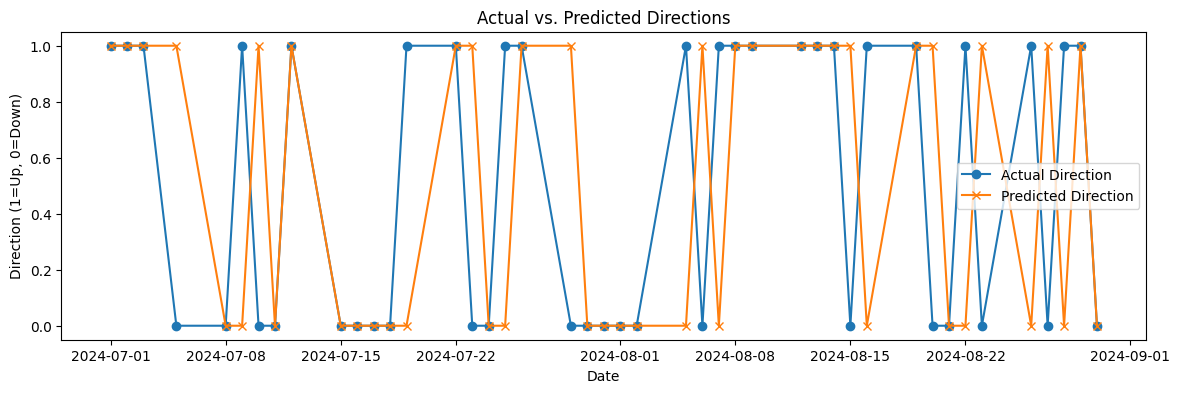

In [ ]:
# Plot actual vs. predicted directions
plt.figure(figsize=(14, 4))
plt.plot(comparison_df['Date'], comparison_df['Actual_Direction'], label='Actual Direction', marker='o')
plt.plot(comparison_df['Date'], comparison_df['Predicted_Direction'], label='Predicted Direction', marker='x')
plt.title('Actual vs. Predicted Directions')
plt.xlabel('Date')
plt.ylabel('Direction (1=Up, 0=Down)')
plt.legend()
plt.show()
